In [1]:
#©Dr Remya
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import time
import os
from PIL import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

C:\Users\Dr.Octopus\AppData\Local\Temp\ipykernel_26980\1555369008.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
dir=r'C:\Users\Dr.Octopus\Downloads\AutismTrainedCNN'
train_dir=os.path.join(dir,'train')
test_dir=os.path.join(dir,'test')
val_dir=os.path.join(dir,'valid')


In [3]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat))
    print('\33[0m') # returns default print color to back to black
    return

In [4]:
classes=os.listdir(train_dir) # class names are the names of the sub directories
class_count=len(classes) # determine number of classes
batch_size=30 # set training batch size
rand_seed=123
start_epoch=0 # specify starting epoch
epochs=30 # specify the number of epochs to run
img_size=224 # use 224 X 224 images compatible with mobilenet model
lr=.001 # specify initial learning rate

In [5]:
def get_bs(dir,b_max):
    # dir is the directory containing the samples, b_max is maximum batch size to allow based on your memory capacity
    # you only want to go through test and validation set once per epoch this function determines needed batch size ans steps per epoch
    length=0
    dir_list=os.listdir(dir)
    for d in dir_list:
        d_path=os.path.join (dir,d)
        length=length + len(os.listdir(d_path))
    batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=b_max],reverse=True)[0]  
    return batch_size,int(length/batch_size)

In [6]:
valid_batch_size, valid_steps=get_bs(val_dir, 100)
test_batch_size, test_steps=get_bs(test_dir,100)


In [7]:
train_gen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input, horizontal_flip=True).flow_from_directory(
        train_dir,  target_size=(img_size, img_size), batch_size=batch_size, seed=rand_seed, class_mode='categorical', color_mode='rgb')

valid_gen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input) .flow_from_directory(val_dir, 
                    target_size=(img_size, img_size), batch_size=valid_batch_size,
                    class_mode='categorical',color_mode='rgb', shuffle=False)
test_gen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(test_dir,
                    target_size=(img_size, img_size), batch_size=test_batch_size,
                    class_mode='categorical',color_mode='rgb', shuffle=False )
test_file_names=test_gen.filenames  # save list of test files names to be used later
test_labels=test_gen.labels # save test labels to be used later


val_file_names=valid_gen.filenames  # save list of test files names to be used later
val_labels=valid_gen.labels # save test labels to be used later

Found 2654 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 280 images belonging to 2 classes.


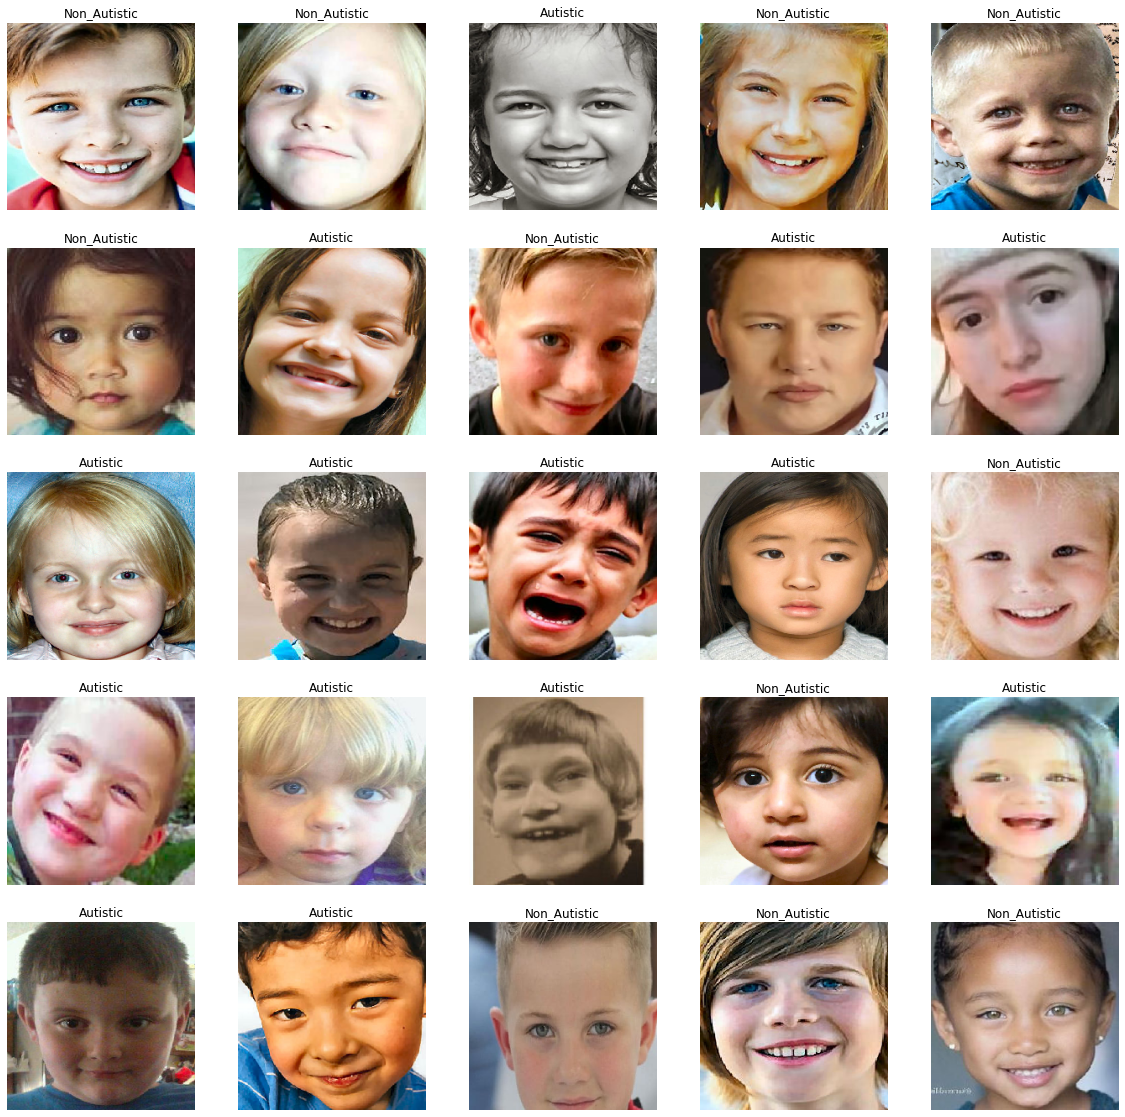

In [8]:
images,labels=next(train_gen)
plt.figure(figsize=(20, 20))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    image=(images[i]+1 )/2
    plt.imshow(image)
    index=int(labels[i][1])
    plt.title(classes[index], color='black')
    plt.axis('off')
plt.show()


In [9]:
_model = tf.keras.applications.densenet.DenseNet201( include_top=False, input_shape=(img_size, img_size,3), pooling='max', weights='imagenet') 
_model.trainable=False
x=_model.layers[-1].output # this is the last layer in the mobilenet model the global max pooling layer
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x=Dense(128, activation='relu')(x)
x=Dropout(rate=.4, seed = 123)(x)
predictions=Dense (len(classes), activation='softmax')(x)
model = Model(inputs=_model.input, outputs=predictions)    
for layer in model.layers:
    layer.trainable=True
model.compile(Adamax(lr=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

74842112/74836368 [==============================] - 14s 0us/step


In [10]:
class LRA(keras.callbacks.Callback):
    best_weights=model.get_weights() # set a class vaiable so weights can be loaded after training is completed
    def __init__(self, patience=2, threshold=.95, factor=.5):
        super(LRA, self).__init__()
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it in self.lr
        self.highest_tracc=0.0 # set highest training accuracy to 0
        self.lowest_vloss=np.inf # set lowest validation loss to infinity
        self.count=0
        msg='\n Starting Training - Initializing Custom Callback'
        print_in_color (msg, (244, 252, 3), (55,65,80))
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy        
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            if acc>self.highest_tracc: # training accuracy improved in the epoch
                msg= f'\n training accuracy improved from  {self.highest_tracc:7.2f} to {acc:7.2f} learning rate held at {lr:9.6f}'
                print_in_color(msg, (0,255,0), (55,65,80))
                self.highest_tracc=acc # set new highest training accuracy
                LRA.best_weights=model.get_weights() # traing accuracy improved so save the weights
                count=0 # set count to 0 since training accuracy improved
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss                    
            else:  # training accuracy did not improve check if this has happened for patience number of epochs if so adjust learning rate
                if self.count>=self.patience -1:
                    self.lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    if v_loss<self.lowest_vloss:
                        self.lowest_vloss=v_loss
                    msg=f'\nfor epoch {epoch +1} training accuracy did not improve for {self.patience } consecutive epochs, learning rate adjusted to {lr:9.6f}'
                    print_in_color(msg, (255,0,0), (55,65,80))
                else:
                    self.count=self.count +1
                    msg=f'\nfor  epoch {epoch +1} training accuracy did not improve, patience count incremented to {self.count}'
                    print_in_color(msg, (255,255,0), (55,65,80))
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            if v_loss< self.lowest_vloss: # check if the validation loss improved
                msg=f'\n for epoch {epoch+1} validation loss improved from  {self.lowest_vloss:7.4f} to {v_loss:7.4}, saving best weights'
                print_in_color(msg, (0,255,0), (55,65,80))
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                LRA.best_weights=model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved               
            else: # validation loss did not improve
                if self.count>=self.patience-1:
                    self.lr=self.lr * self.factor
                    msg=f' \nfor epoch {epoch+1} validation loss failed to improve for {self.patience} consecutive epochs, learning rate adjusted to {self.lr:9.6f}'
                    self.count=0 # reset counter
                    print_in_color(msg, (255,0,0), (55,65,80))
                    tf.keras.backend.set_value(model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                else: 
                    self.count =self.count +1 # increment the count
                    msg=f' \nfor epoch {epoch+1} validation loss did not improve patience count incremented to {self.count}'
                    print_in_color(msg, (255,255,0), (55,65,80))

In [11]:
def tr_plot(tr_data):
    #Plot the training and validation data
    history=tr_data.history
    tacc=results.history['accuracy']
    tloss=results.history['loss']
    vacc=results.history['val_accuracy']
    vloss=results.history['val_loss']
    Epoch_count=len(tloss)
    Epochs=[]
    for i in range (0,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    val_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1)
    vc_label='best epoch= '+ str(index_acc + 1)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1,val_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [ ]:
callbacks=[LRA()]
results=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=test_gen,
               validation_steps=test_steps,  shuffle=True,  initial_epoch=start_epoch)


 Starting Training - Initializing Custom Callback

Epoch 1/30
89/89 [==============================] - ETA: 0s - loss: 0.6680 - accuracy: 0.7084 
 training accuracy improved from     0.00 to    0.71 learning rate held at  0.001000

89/89 [==============================] - 1074s 12s/step - loss: 0.6680 - accuracy: 0.7084 - val_loss: 1.1090 - val_accuracy: 0.7214
Epoch 2/30
89/89 [==============================] - ETA: 0s - loss: 0.4574 - accuracy: 0.7965 
 training accuracy improved from     0.71 to    0.80 learning rate held at  0.001000

89/89 [==============================] - 1030s 12s/step - loss: 0.4574 - accuracy: 0.7965 - val_loss: 5.3265 - val_accuracy: 0.6857
Epoch 3/30
89/89 [==============================] - ETA: 0s - loss: 0.3602 - accuracy: 0.8463 
 training accuracy improved from     0.80 to    0.85 learning rate held at  0.001000

89/89 [==============================] - 2264s 25s/step - loss: 0.3602 - accuracy: 0.8463 - val_loss: 0.3428 - val_accuracy: 0.8357
Epoch 4/3

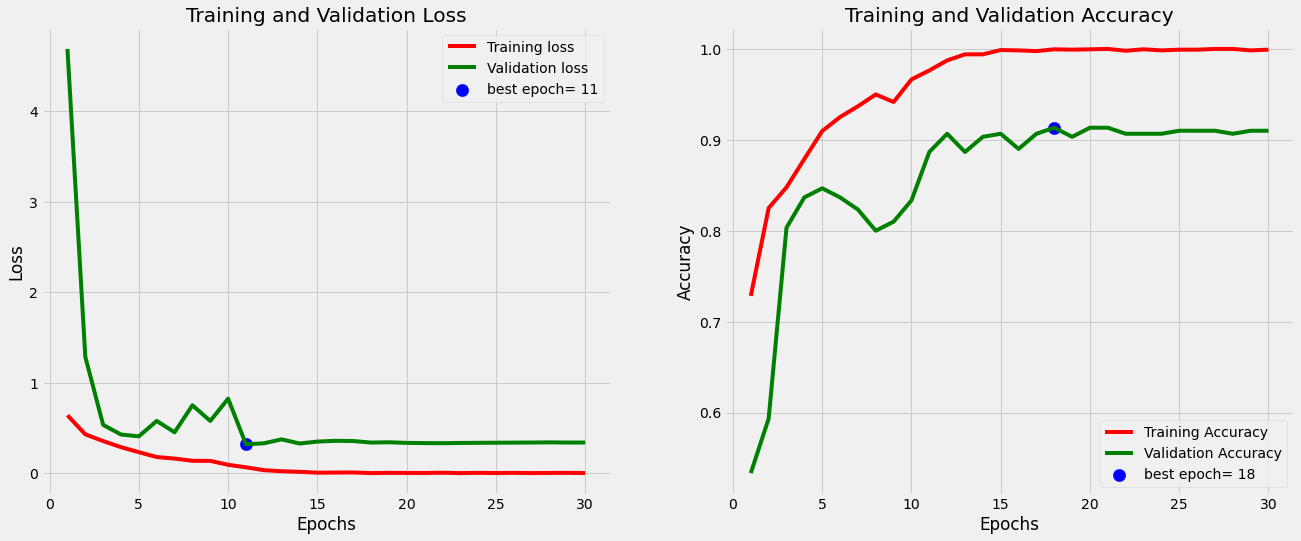

In [13]:
tr_plot(results)

In [14]:
model.set_weights(LRA.best_weights)
acc_val=model.evaluate( valid_gen, batch_size=valid_batch_size, verbose=1, steps=valid_steps)[1]* 100
msg_val=f'accuracy on the test set is {acc_val:5.2f} %'
print_in_color(msg_val, (0,255,0),(55,65,80))

1/1 [==============================] - 0s 999us/step - loss: 0.7398 - accuracy: 0.7900
accuracy on the test set is 79.00 %



In [15]:
out_dir='E:\\'
save_loc=os.path.join(out_dir, str(acc_val)[:str(acc_val).rfind('.')+3] + '.h5')
model.save(save_loc)

# From here the real-live testing applied

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import time
import os
#from PIL import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)
model = tf.keras.models.load_model("E:\\87.00.h5")

In [2]:
def get_bs(dir,b_max):
    # dir is the directory containing the samples, b_max is maximum batch size to allow based on your memory capacity
    # you only want to go through test and validation set once per epoch this function determines needed batch size ans steps per epoch
    length=0
    dir_list=os.listdir(dir)
    for d in dir_list:
        d_path=os.path.join (dir,d)
        length=length + len(os.listdir(d_path))
    batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=b_max],reverse=True)[0]  
    return batch_size,int(length/batch_size)

Found 1 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1]
{'autistic': 0, 'non_autistic': 1}
(224, 224, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

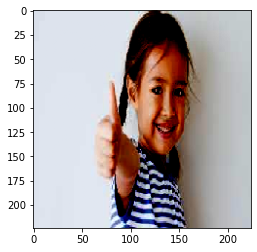

In [3]:
dir=r'E:\aut'
test2_dir=os.path.join(dir,'test2')
test2_batch_size, test2_steps=get_bs(test2_dir,100)
classes=os.listdir(test2_dir) # class names are the names of the sub directories
class_count=len(classes) # determine number of classes
batch_size=30 # set training batch size
rand_seed=123
start_epoch=0 # specify starting epoch
epochs=30 # specify the number of epochs to run
img_size=224 # use 224 X 224 images compatible with mobilenet model
lr=.001 # specify initial learning rate
test2_gen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(test2_dir,
                    target_size=(img_size, img_size), batch_size=test2_batch_size,
                    class_mode='categorical',color_mode='rgb', shuffle=False )
test2_file_names=test2_gen.filenames  # save list of test files names to be used later
test2_labels=test2_gen.labels # save test labels to be used later
Y_pred = model.predict(test2_gen)

y_pred=[]
for i in range(len(Y_pred)):
    if Y_pred[i][0]<0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
print (y_pred)
print(test2_gen.class_indices)
x,y=next(test2_gen)
print(x[0].shape)
plt.imshow(x[0,:,:,:])
plt.show